# Setting up the environment

The following notebook is created within Colab, some initalizations are therefore specific to the platform.

> For suggested folder structure see the repo's README.

### Imports

> The logging of the following notebook requires an account on Weights and Biases (sign up [here](https://wandb.ai/site)).

Once you have the account, send me your email so I can add you to the team with which we can share out logs.




In [ ]:
!pip install segmentation-models-pytorch --quiet
!pip install pytorch-lightning --quiet
!pip install wandb --quiet
!pip install albumentations==1.1.0 --quiet
!wandb login 73a234c5692d141ace22c52447829be299f642a0x # change this with your Weights & Biases login number

     |████████████████████████████████| 88 kB 2.0 MB/s 
     |████████████████████████████████| 376 kB 5.5 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
     |████████████████████████████████| 526 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 63.8 MB/s 
     |████████████████████████████████| 132 kB 22.7 MB/s 
     |████████████████████████████████| 332 kB 40.6 MB/s 
     |████████████████████████████████| 829 kB 18.9 MB/s 
     |████████████████████████████████| 1.1 MB 50.6 MB/s 
     |████████████████████████████████| 192 kB 52.6 MB/s 
     |████████████████████████████████| 160 kB 70.6 MB/s 
     |████████████████████████████████| 271 kB 65.6 MB/s 
     |████████████████████████████████| 1.7 MB 2.1 MB/s 
     |████████████████████████████████| 97 kB 7.8 MB/s 
     |████████████████████████████████| 180 kB 67.2 MB/s 
     |████████████████████████████████| 140 kB 70.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |███████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import albumentations as A
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import shutil
import zipfile
from pathlib import Path
import itertools
import wandb

#torch related imports
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.utils.data import random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# model stuff
import segmentation_models_pytorch as smp

### Initializations

In [ ]:
# Static stuff initialization
zip_folder = '/content/drive/MyDrive/Segmentality/raw_data.zip'
data = '/content/data/'

test_folder = os.path.join(data, 'test_data')
train_folder = os.path.join(data, 'train_data')
raw_folder = os.path.join(data, 'raw_data.zip')
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


classes = {'front_door': (20, 100, 20),
'back_door': (250, 250, 10),
'fender': (20, 20, 250),
'frame': (10, 250, 250),
'bumper': (250, 10, 250),
'hood': (250, 150, 10),
'back_bumper': (150, 10, 150),
'trunk': (10, 250, 10)}

# order in the chaos
np.random.seed(42)

### Function definitions

In [ ]:
# lists files from directory
def fileList(source,file_type): 
    file_list = []
    for root, dirnames, filenames in os.walk(source):
        for filename in filenames:
            if filename.endswith((file_type)):
                 file_list.append(os.path.join(root, filename))
    return sorted(file_list)

# lists files on steroids, dict.key <- folder name
def sorted_dict(source): 
  image_dict = {}
  for root, dirnames, filenames in os.walk(source):
    if root == source:
      for name in dirnames:
          image_dict[name] = []
    else:

      image_dict[Path(root).stem] = sorted([os.path.join(root,name) for name in filenames])
    
    # in case there is no sub directory
    if not image_dict: 
      image_dict[Path(root).stem] = sorted([os.path.join(root,name) for name in filenames])
          
  return image_dict

# samples the provided ratio from the subsets
def image_type_sampler(dict, primary=1.0, primary_repetition = 1, cyclegan = 0.2, door=0.2, opel=0.2):

  # chance to add primary images multiple times
  _primary_all = []
  for _ in itertools.repeat(None, primary_repetition):
    _primary = random.sample(dict['primary'], int(len(dict['primary'])*primary))
    _primary_all = _primary_all + _primary

  # other lower-tier images
  _cyclegan = random.sample(dict['cyclegan'], int(len(dict['cyclegan'])*cyclegan))
  _door = random.sample(dict['door'], int(len(dict['door'])*door))
  _opel = random.sample(dict['opel'], int(len(dict['opel'])*opel))

  # combine the sampled lists
  _combined = list(itertools.chain(_primary_all, _cyclegan, _door, _opel))

  return random.sample(_combined, len(_combined)) # shuffle them (not to corrupt train-valid split)


def _get_labels(dictionary):
  return list(dictionary.keys())

def _resolve_normalize(input, mean, std): # resolve the Deloite normalization issue
  input[0,:,:]=(input[0,:,:]+mean[0]/std[0]-mean[0])/std[0]
  input[1,:,:]=(input[1,:,:]+mean[1]/std[1]-mean[1])/std[1]
  input[2,:,:]=(input[2,:,:]+mean[2]/std[2]-mean[2])/std[2]
  return input

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
            return tensor


## Data preparation

 Unzipping data

In [ ]:
if not os.path.isdir('data/'):
  # create folders
  os.makedirs(data, exist_ok=True)

  # copy over from drive and unzip
  shutil.copy(zip_folder, data)

  with zipfile.ZipFile(raw_folder, 'r') as zip_ref:
      zip_ref.extractall(data)

Sampling the training set

In [ ]:
# looping through the subfolders
train_dict = sorted_dict(train_folder)
test_dict = sorted_dict(test_folder)

# sampling ratios of the different training images
train_images = image_type_sampler(train_dict, primary=1.0, primary_repetition=4, cyclegan=0.0, door=0.1, opel=0.1)
test_images = test_dict['test_data']

### Generate data augmentation pipeline

`p=0.5` is the probability of the augmentation getting loaded.

In [ ]:
train_transform = A.Compose([
                    #A.HorizontalFlip(),
                    #A.VerticalFlip(p=0.1),
                    #A.Rotate(),
                    A.ShiftScaleRotate(p=1.0),
                    #A.ColorJitter(),
                    #A.RandomCrop(),
                    A.GridDistortion(),
                    A.GaussianBlur(),
                    A.Cutout(num_holes=10, max_h_size=10, max_w_size=10, fill_value=255, p=0.5),
                    A.RandomGridShuffle(grid=(5,5), p=0.1),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

valid_transform = A.Compose([
                       A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_transform = A.Compose([
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

test_transform_show = A.Compose([
                                 A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])                                
                                 

# save the transformations into a dictionary
valid_transform_dict = A.to_dict(valid_transform)
train_transform_dict = A.to_dict(train_transform)
test_transform_dict = A.to_dict(test_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


## Custom loader for segmentation masks



In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, images: list, transform):
    self.image_list = images
    self.transform = transform
    self.mean = [0.485, 0.456, 0.406]
    self.std = [0.229, 0.224, 0.225]
    self.inputs_dtype = torch.float32
    self.targets_dtype = torch.long

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx: int):
    input = np.load(self.image_list[idx])
    input = _resolve_normalize(input, self.mean, self.std)

    image = input[0:3].transpose(1,2,0)*255   
    mask = input[3:12].transpose(1,2,0) # changed for multi-channel input

    transformed_data = self.transform(image = image, mask = mask)

    # cast to tensor
    image, mask = torch.from_numpy(transformed_data['image'].transpose(2,0,1)).type(self.inputs_dtype), torch.from_numpy(transformed_data['mask'].transpose(2,0,1)).type(self.targets_dtype)

    return {'image': image, 'mask': mask}

# Training the model

I have reorganized the training loop with the framework called [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) as it might make easier logging and visualizing things than a self-factored code. It is still a custom build for our segmentation usecase (both Dataset and Trainer Class) so please ask if something is not clear.


## Configuration file for training

In [ ]:
config = {
    'learning_rate': 1e-4,
    'valid_size': 0.2,
    'seed': 42,
    'batch_size': 32,
    'num_workers': 2,
    'classes': 9,
    'valid_transform': valid_transform_dict['transform']['transforms'],
    'train_transform': train_transform_dict['transform']['transforms']} 

## Trainer Class
A LightningModule organizes your PyTorch code into 5 sections:

  - Computations (init).

  - Train loop (training_step)

  - Validation loop (validation_step)

  - Test loop (test_step)

  - Optimizers (configure_optimizers)

This is a customised implementation of the trainer class.

Model loaded from the following [SMP](https://github.com/qubvel/segmentation_models.pytorch#start) library.

In [ ]:
class SegmenTrainer(pl.LightningModule):
  def __init__(self, config, images_list: list, test_images_list: list):
    super().__init__()
    self.config = config
    self.images_list = images_list
    self.test_images_list = test_images_list

    # Define the pre-trained model and encoder
    self.model = smp.UnetPlusPlus(encoder_name='resnet34', classes=self.config['classes'], activation="softmax", encoder_weights='imagenet')
    # self.model = smp.DeepLabV3Plus(encoder_name='resnet34', classes=self.config['classes'], activation="softmax", encoder_weights='imagenet')

    self.losses = smp.losses.DiceLoss(mode='multilabel', from_logits=False) # changed for multi-channel input

  def forward(self, x):
    return self.model(x) 

  def setup(self, stage = 0):

    # for reproducability, it is always the same random split
    self.train_set, self.valid_set = train_test_split(self.images_list, test_size=self.config['valid_size'], random_state = self.config['seed'], shuffle=True)
    self.test_set = self.test_images_list


  def train_dataloader(self):
    train_data = DataLoader(SegmentationDataset(self.train_set, train_transform),
                                         batch_size = self.config['batch_size'],
                                         num_workers = self.config['num_workers'],
                                         drop_last = False)
    print("Train dataloader = ", len(train_data.sampler))
    return train_data

  def val_dataloader(self):
    valid_data = DataLoader(SegmentationDataset(self.valid_set, valid_transform),
                                         batch_size = self.config['batch_size'],
                                         num_workers = self.config['num_workers'],
                                         drop_last = False)
    print("Valid dataloader = ", len(valid_data.sampler))
    return valid_data

  def test_dataloader(self):
    test_data = DataLoader(SegmentationDataset(self.test_set, test_transform),
                                         batch_size = 1,
                                         num_workers = self.config['num_workers'],
                                         drop_last = True)
    print("Test dataloader = ", len(test_data.sampler))
    return test_data

  def training_step(self, batch, idx):

    # load in images and masks from the dataloader
    img = batch['image']
    mask = batch['mask']

    # forward propagation step
    output = self.forward(img)

    # calculate losses and log it for tensorboard
    loss = self.losses(output,mask)
    self.log("train_loss", loss)

    return loss


  def validation_step(self, batch, idx):

    # load in images and masks from the dataloader
    img = batch['image']
    mask = batch['mask']

    # forward propagation step
    output = self.forward(img)

    # calculate losses and log it for tensorboard
    loss = self.losses(output,mask)
    self.log("valid_loss", loss)

    return loss


  def test_step(self, batch, idx):

    # load in images and masks from the dataloader
    img = batch['image']
    mask = batch['mask']

    # forward propagation step
    output = self.forward(img)

    # calculate losses and log it for tensorboard
    loss = self.losses(output,mask)
    self.log("test_loss", loss)

    return loss


  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = self.config['learning_rate'])
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(T_0=10, T_mult=2,optimizer=optimizer)
    #self.log("learning_rate", scheduler)
    #return [optimizer], [scheduler]
    return optimizer


## Training the network

Here we are initializing the Trainer ([docs](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html)) and specify the [early_stopping_callback](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html) which saves us from overfitting and defining the [checkpoint_callback](https://pytorch-lightning.readthedocs.io/en/latest/common/weights_loading.html) which is the metric defining when we save the model instance.

Lastly we initiate the SegmenTrainer module we created with the configurations specified, and the images we would like train on.


In [ ]:
wandb.init(project="car_part_segmentation", entity="segmentality", config=config) # IMPORTANT: moved this down here and am passing all our configs

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test_loss,▁
train_loss,██▇▆▆▅▅▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▇▇▆▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,45
test_loss,0.24913
train_loss,0.09303
trainer/global_step,1472
valid_loss,0.07706


In [ ]:
early_stop_callback = EarlyStopping(monitor="valid_loss", min_delta=0.01, patience=5, verbose=False, mode= "min")
checkpoint_callback = ModelCheckpoint(monitor='valid_loss', mode='min')

trainer = pl.Trainer(
    gpus = 1,
    logger = WandbLogger(project='car_part_segmentation'),
    callbacks=[early_stop_callback,
               checkpoint_callback],
    #auto_lr_find = True,
    auto_select_gpus = True,
    log_every_n_steps = 10
)

pipeline = SegmenTrainer(config, train_images, test_images)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(pipeline)
trainer.test(pipeline)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type         | Params
----------------------------------------
0 | model  | UnetPlusPlus | 26.1 M
1 | losses | DiceLoss     | 0     
----------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.319   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/None/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Valid dataloader =  157


/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Train dataloader =  627


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test dataloader =  30


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3585144877433777}
--------------------------------------------------------------------------------


[{'test_loss': 0.3585144877433777}]

# Inference

The inference has to be implemented into the training loop once we have a clear test-set of images. So we could automatically by every training define our 'Dice' score on the test set. 

For now, we are loading the best checkpoint after training, and taking a random sample from the training set (not valid metric, just sanity check).

> If the checkpoint loading complains, put manually the checkpoint you want to load.

In [ ]:
# load the ckpt
ckpt = torch.load(checkpoint_callback.best_model_path)
#manual_checkpoint = '/content/drive/MyDrive/Segmentality/logs/car_part_segmentation/1epdcwmt/checkpoints/epoch=108-step=3160.ckpt'
#ckpt = torch.load(manual_checkpoint)

# load trainer class if run sperately
model = SegmenTrainer(config, train_images, test_images)
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

Plotting the segmented masks with the correct color

In [ ]:
def segment_colour(image, mask, pred, classes):
    list_colors = [colors for colors in classes.values()]
    image_target = image.copy()
    image_pred = image.copy()
    for idx, color in enumerate(list_colors):
        color = tuple(i/255 for i in color)
        image_target[mask[0][idx+1] == 1] = color
    for idx, color in enumerate(list_colors):
        color = tuple(i/255 for i in color)
        image_pred[pred[0][idx+1] >= 0.9] = color
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image_target)
    plt.subplot(1,2,2)
    plt.imshow(image_pred)

Sample number 22 and name /content/data/train_data/opel/OPEL_0483.npy


/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


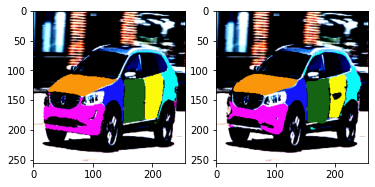

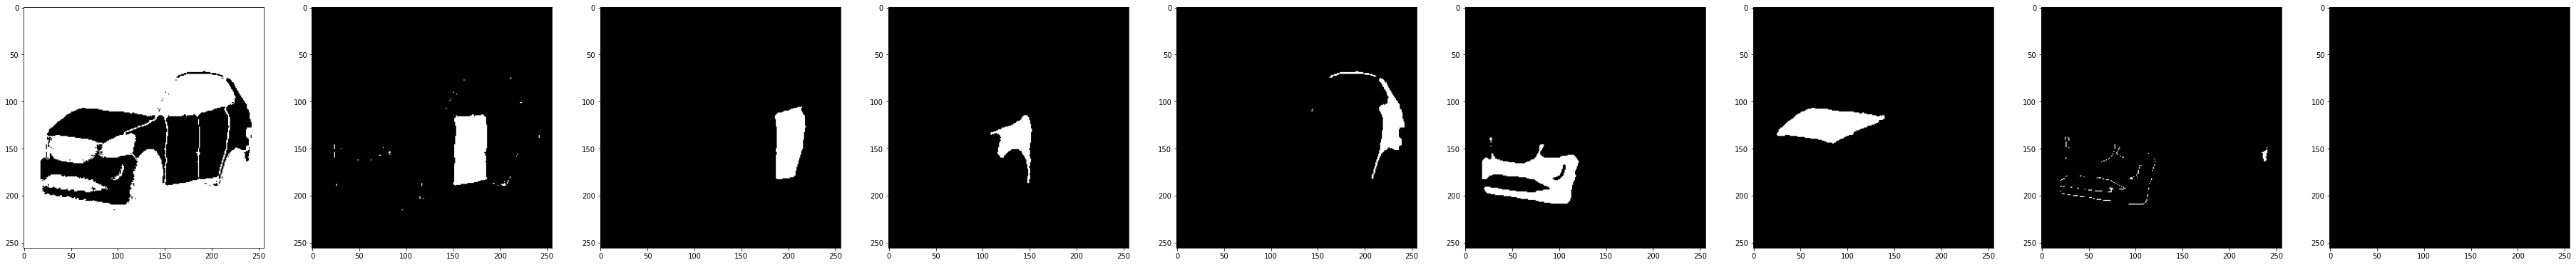

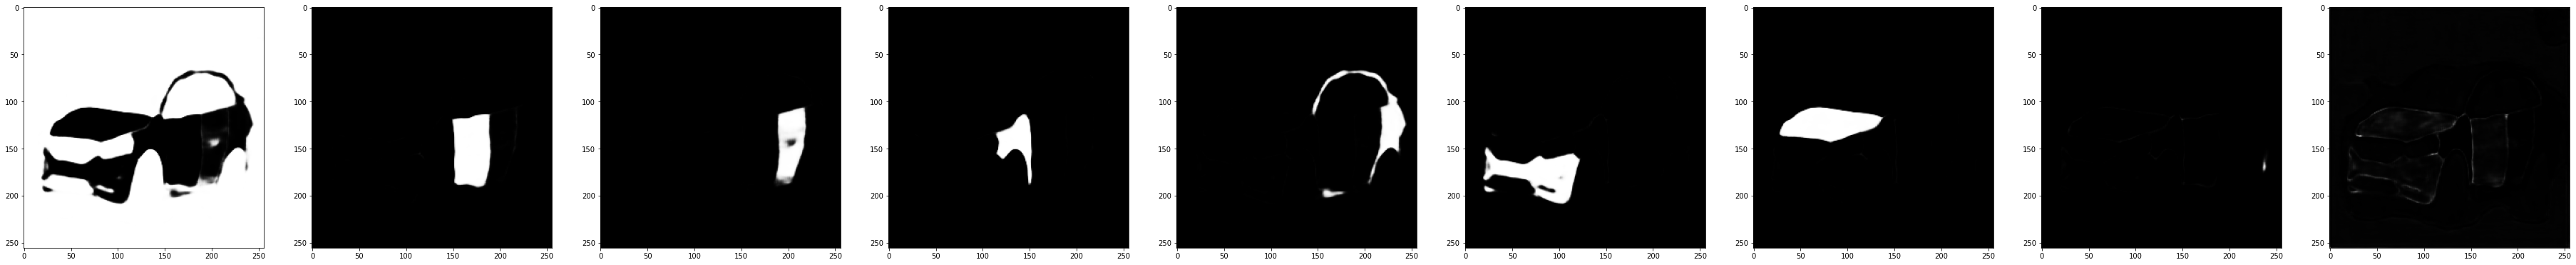

In [ ]:
# Pick a random sample from the test set
i = np.random.randint(1,len(test_images))
print(f'Sample number {i-1} and name {train_images[i-1]}')
dataset = SegmentationDataset(test_images[i-1:i], test_transform_show)
dataload = DataLoader(dataset)

# Test correct load
for data in dataload:
  img = data['image']
  pred = model(img)
  label = data['mask']
  img = inverse_normalize(img,mean,std).squeeze().permute(1,2,0)

  # Plot the the ground truth and the output to the cars
  segment_colour(img.cpu().detach().numpy(), label.cpu().detach().numpy(), pred.cpu().detach().numpy(), classes)

  # Inspect ground truth labels
  plt.figure(figsize=(64,20))
  for idx in range(9):
    plt.subplot(1,9,idx+1)
    plt.imshow(label.squeeze()[idx], cmap='gray')
  plt.show()

  # Inspect output labels
  plt.figure(figsize=(64,20))
  for idx in range(9):
    plt.subplot(1,9,idx+1)
    plt.imshow(pred.squeeze().cpu().detach().numpy()[idx], cmap='gray')
  plt.show()

# Save the log files to our drive folder

In [ ]:
!cp -r /content/wandb /content/drive/MyDrive/Segmentality/logs/wandb/
!cp -r /content/car_part_segmentation/ /content/drive/MyDrive/Segmentality/logs/

In [ ]:
# !rm -rf /content/car_part_segmentation